In [4]:
# NAIP and Forest Mask Tile Comparison
# This notebook helps verify that forest mask tiles are correctly aligned with NAIP imagery

import matplotlib.pyplot as plt
import numpy as np
import random
from pathlib import Path
from PIL import Image
import rasterio
from matplotlib.patches import Rectangle
import ipywidgets as widgets
from IPython.display import display

# Configuration - Update these paths
NAIP_TILES_DIR = Path("../data/raw/naip/wv_demo/")  # Directory with NAIP PNG files
MASK_TILES_DIR = Path("../data/processed/tiles/masks")  # Directory with mask TIF files

def get_matching_tile_pairs():
    """Find all NAIP tiles that have corresponding mask tiles"""
    naip_tiles = list(NAIP_TILES_DIR.glob("*.png")) + list(NAIP_TILES_DIR.glob("*.jpg"))
    
    pairs = []
    for naip_tile in naip_tiles:
        # Extract coordinates from filename
        try:
            z, x, y = map(int, naip_tile.stem.split("_"))
            mask_tile = MASK_TILES_DIR / f"{z}_{x}_{y}_mask.tif"
            
            if mask_tile.exists():
                pairs.append((naip_tile, mask_tile))
        except:
            continue
    
    return pairs

def load_naip_tile(naip_path):
    """Load NAIP tile as RGB array"""
    img = Image.open(naip_path)
    return np.array(img)

def load_mask_tile(mask_path):
    """Load mask tile as binary array"""
    with rasterio.open(mask_path) as src:
        mask = src.read(1)
        # Get the transform for coordinate info
        transform = src.transform
        bounds = src.bounds
    return mask, transform, bounds

def plot_tile_comparison(naip_path, mask_path, overlay_alpha=0.5):
    """Plot NAIP tile, mask tile, and overlay comparison"""
    
    # Load data
    naip_img = load_naip_tile(naip_path)
    mask_img, transform, bounds = load_mask_tile(mask_path)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    # 1. NAIP imagery
    axes[0, 0].imshow(naip_img)
    axes[0, 0].set_title(f'NAIP Imagery\n{naip_path.name}', fontsize=12)
    axes[0, 0].set_xlabel('Pixel X')
    axes[0, 0].set_ylabel('Pixel Y')
    
    # 2. Forest mask
    axes[0, 1].imshow(mask_img, cmap='Greens', vmin=0, vmax=1)
    axes[0, 1].set_title(f'Forest Mask\n{mask_path.name}', fontsize=12)
    axes[0, 1].set_xlabel('Pixel X')
    axes[0, 1].set_ylabel('Pixel Y')
    
    # 3. Overlay - mask on top of NAIP
    axes[1, 0].imshow(naip_img)
    # Create a colored mask for overlay (green with transparency)
    colored_mask = np.zeros((*mask_img.shape, 4))
    colored_mask[mask_img > 0] = [0, 1, 0, overlay_alpha]  # Green with alpha
    axes[1, 0].imshow(colored_mask)
    axes[1, 0].set_title(f'Overlay: Green = Forest Mask\n(Alpha = {overlay_alpha})', fontsize=12)
    axes[1, 0].set_xlabel('Pixel X')
    axes[1, 0].set_ylabel('Pixel Y')
    
    # 4. Side-by-side comparison
    combined = np.hstack([naip_img, np.stack([mask_img*255]*3, axis=-1)])
    axes[1, 1].imshow(combined)
    axes[1, 1].axvline(x=256, color='red', linewidth=2, linestyle='--')
    axes[1, 1].set_title('Side by Side: NAIP (left) | Mask (right)', fontsize=12)
    axes[1, 1].set_xlabel('Combined Pixel X')
    axes[1, 1].set_ylabel('Pixel Y')
    
    # Add coordinate info
    z, x, y = map(int, naip_path.stem.split("_"))
    coord_text = f'Tile: z={z}, x={x}, y={y}\n'
    coord_text += f'Bounds: {bounds.left:.1f}, {bounds.bottom:.1f}, {bounds.right:.1f}, {bounds.top:.1f}\n'
    coord_text += f'Forest pixels: {np.sum(mask_img > 0)} / {mask_img.size} ({100*np.sum(mask_img > 0)/mask_img.size:.1f}%)'
    
    fig.suptitle(coord_text, fontsize=14, y=0.02)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def interactive_tile_browser():
    """Create interactive widget to browse tile pairs"""
    pairs = get_matching_tile_pairs()
    
    if not pairs:
        print("No matching tile pairs found! Check your directory paths.")
        return
    
    print(f"Found {len(pairs)} matching tile pairs")
    
    # Create dropdown for tile selection
    tile_options = [(f"{pair[0].stem} ({i+1}/{len(pairs)})", i) for i, pair in enumerate(pairs)]
    tile_dropdown = widgets.Dropdown(
        options=tile_options,
        description='Select Tile:',
        style={'description_width': 'initial'}
    )
    
    # Alpha slider for overlay transparency
    alpha_slider = widgets.FloatSlider(
        value=0.5,
        min=0.0,
        max=1.0,
        step=0.1,
        description='Overlay Alpha:',
        style={'description_width': 'initial'}
    )
    
    # Random tile button
    random_button = widgets.Button(description="Random Tile")
    
    def on_random_click(b):
        tile_dropdown.value = random.randint(0, len(pairs)-1)
    
    random_button.on_click(on_random_click)
    
    # Display function
    def show_comparison(tile_idx, alpha):
        naip_path, mask_path = pairs[tile_idx]
        plot_tile_comparison(naip_path, mask_path, alpha)
    
    # Create interactive plot
    interactive_plot = widgets.interactive(show_comparison, 
                                         tile_idx=tile_dropdown, 
                                         alpha=alpha_slider)
    
    display(widgets.VBox([
        widgets.HBox([tile_dropdown, random_button]),
        alpha_slider,
        interactive_plot.children[-1]
    ]))

def quick_random_comparison(n_samples=3):
    """Show a few random tile comparisons"""
    pairs = get_matching_tile_pairs()
    
    if not pairs:
        print("No matching tile pairs found! Check your directory paths.")
        return
    
    print(f"Found {len(pairs)} matching tile pairs")
    print(f"Showing {n_samples} random samples:\n")
    
    random_pairs = random.sample(pairs, min(n_samples, len(pairs)))
    
    for i, (naip_path, mask_path) in enumerate(random_pairs):
        print(f"\n--- Sample {i+1} ---")
        plot_tile_comparison(naip_path, mask_path)

def check_alignment_statistics():
    """Print statistics about the tile pairs"""
    pairs = get_matching_tile_pairs()
    
    if not pairs:
        print("No matching tile pairs found!")
        return
    
    print(f"Alignment Check Statistics:")
    print(f"- Total matching pairs: {len(pairs)}")
    
    forest_percentages = []
    empty_masks = 0
    
    for naip_path, mask_path in pairs[:50]:  # Sample first 50 to avoid long computation
        try:
            mask_img, _, _ = load_mask_tile(mask_path)
            forest_pixels = np.sum(mask_img > 0)
            total_pixels = mask_img.size
            forest_pct = 100 * forest_pixels / total_pixels
            forest_percentages.append(forest_pct)
            
            if forest_pixels == 0:
                empty_masks += 1
                
        except Exception as e:
            print(f"Error processing {mask_path}: {e}")
    
    if forest_percentages:
        print(f"- Average forest coverage: {np.mean(forest_percentages):.1f}%")
        print(f"- Forest coverage range: {np.min(forest_percentages):.1f}% - {np.max(forest_percentages):.1f}%")
        print(f"- Tiles with no forest: {empty_masks}")
        print(f"- Tiles with >50% forest: {sum(1 for p in forest_percentages if p > 50)}")

# Main execution
if __name__ == "__main__":
    print("NAIP and Forest Mask Tile Comparison Tool")
    print("=" * 50)
    
    # First, check if directories exist
    if not NAIP_TILES_DIR.exists():
        print(f"ERROR: NAIP tiles directory not found: {NAIP_TILES_DIR}")
        print("Please update the NAIP_TILES_DIR path at the top of this notebook")
    elif not MASK_TILES_DIR.exists():
        print(f"ERROR: Mask tiles directory not found: {MASK_TILES_DIR}")
        print("Please update the MASK_TILES_DIR path at the top of this notebook")
    else:
        # Show statistics
        check_alignment_statistics()
        
        print("\nTo start visual inspection, run one of these:")
        print("1. quick_random_comparison(5)  # Show 5 random comparisons")
        print("2. interactive_tile_browser()  # Interactive browser with dropdown")

# Uncomment one of these lines to run automatically:
# quick_random_comparison(3)
# interactive_tile_browser()

NAIP and Forest Mask Tile Comparison Tool
Alignment Check Statistics:
- Total matching pairs: 18408
- Average forest coverage: 63.0%
- Forest coverage range: 0.0% - 100.0%
- Tiles with no forest: 5
- Tiles with >50% forest: 31

To start visual inspection, run one of these:
1. quick_random_comparison(5)  # Show 5 random comparisons
2. interactive_tile_browser()  # Interactive browser with dropdown


Found 18408 matching tile pairs
Showing 5 random samples:


--- Sample 1 ---


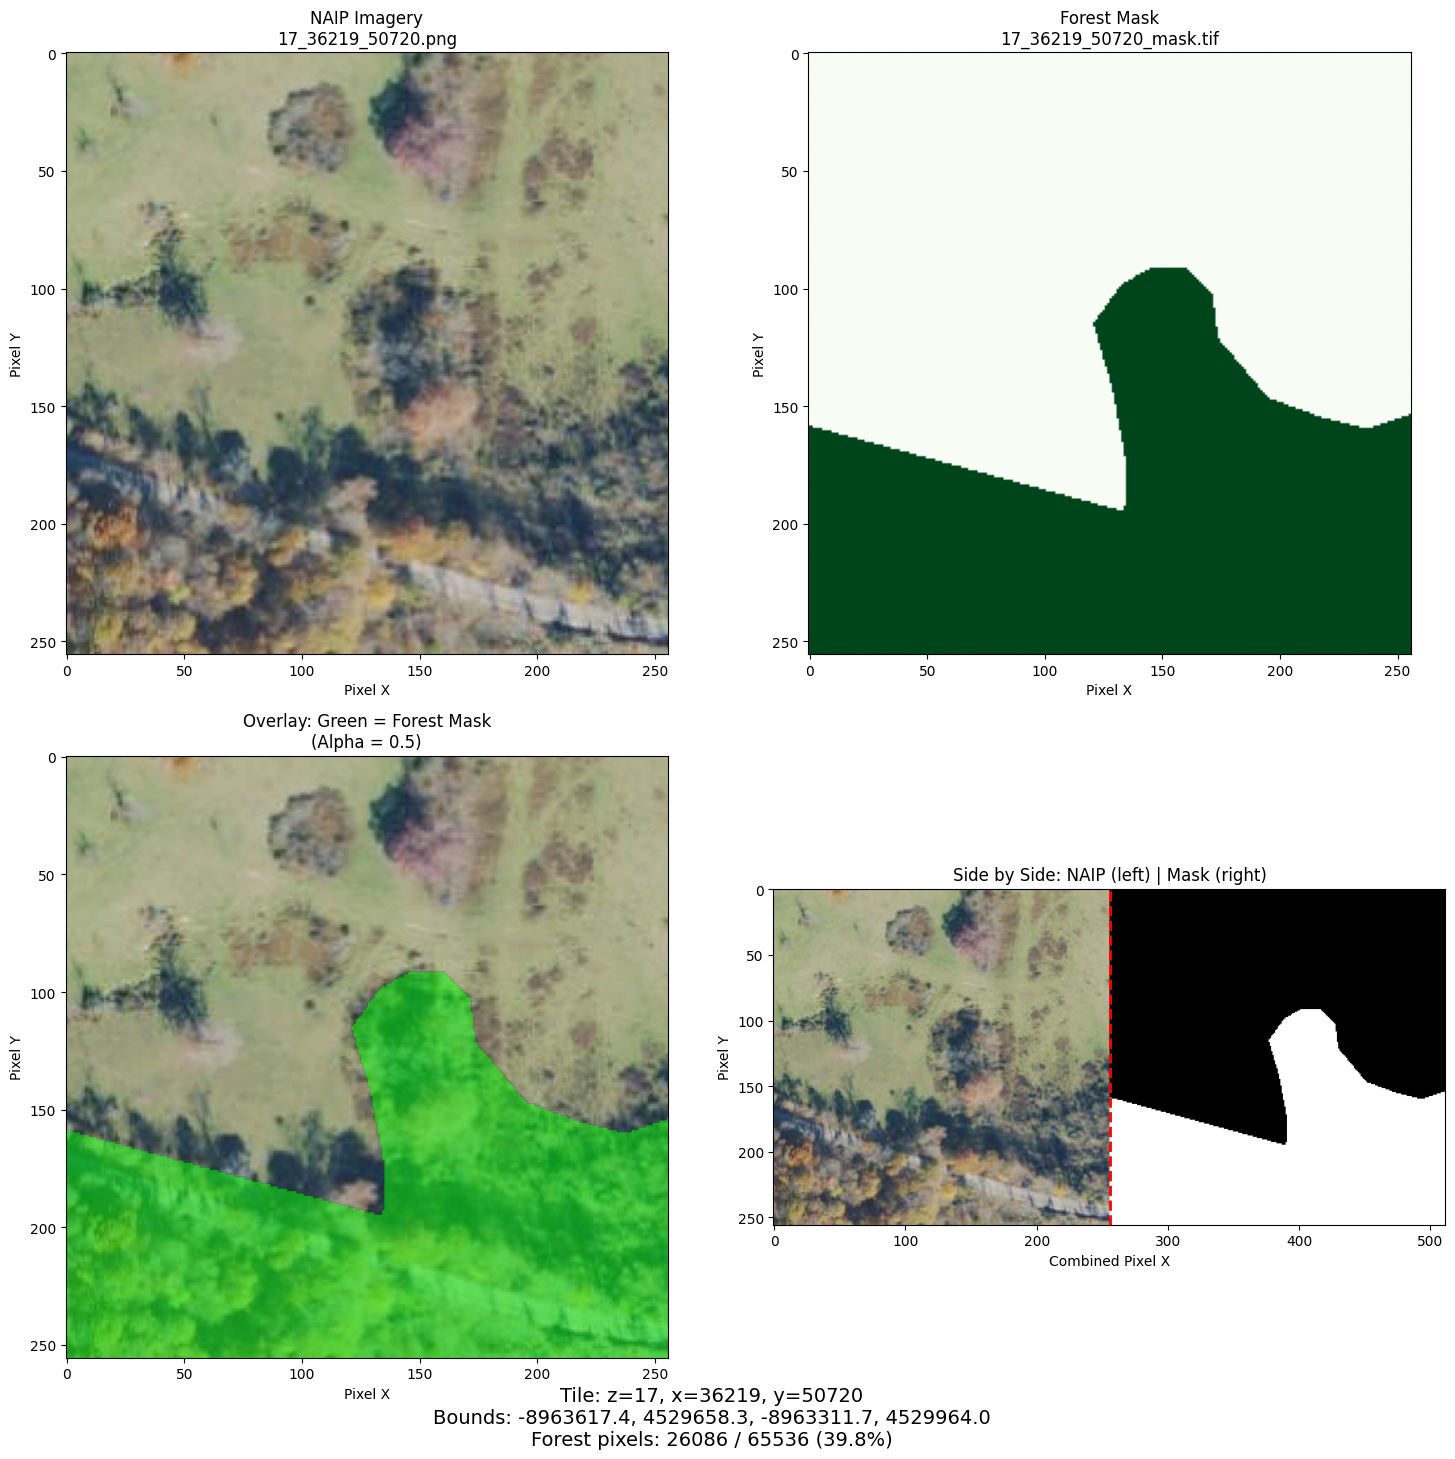


--- Sample 2 ---


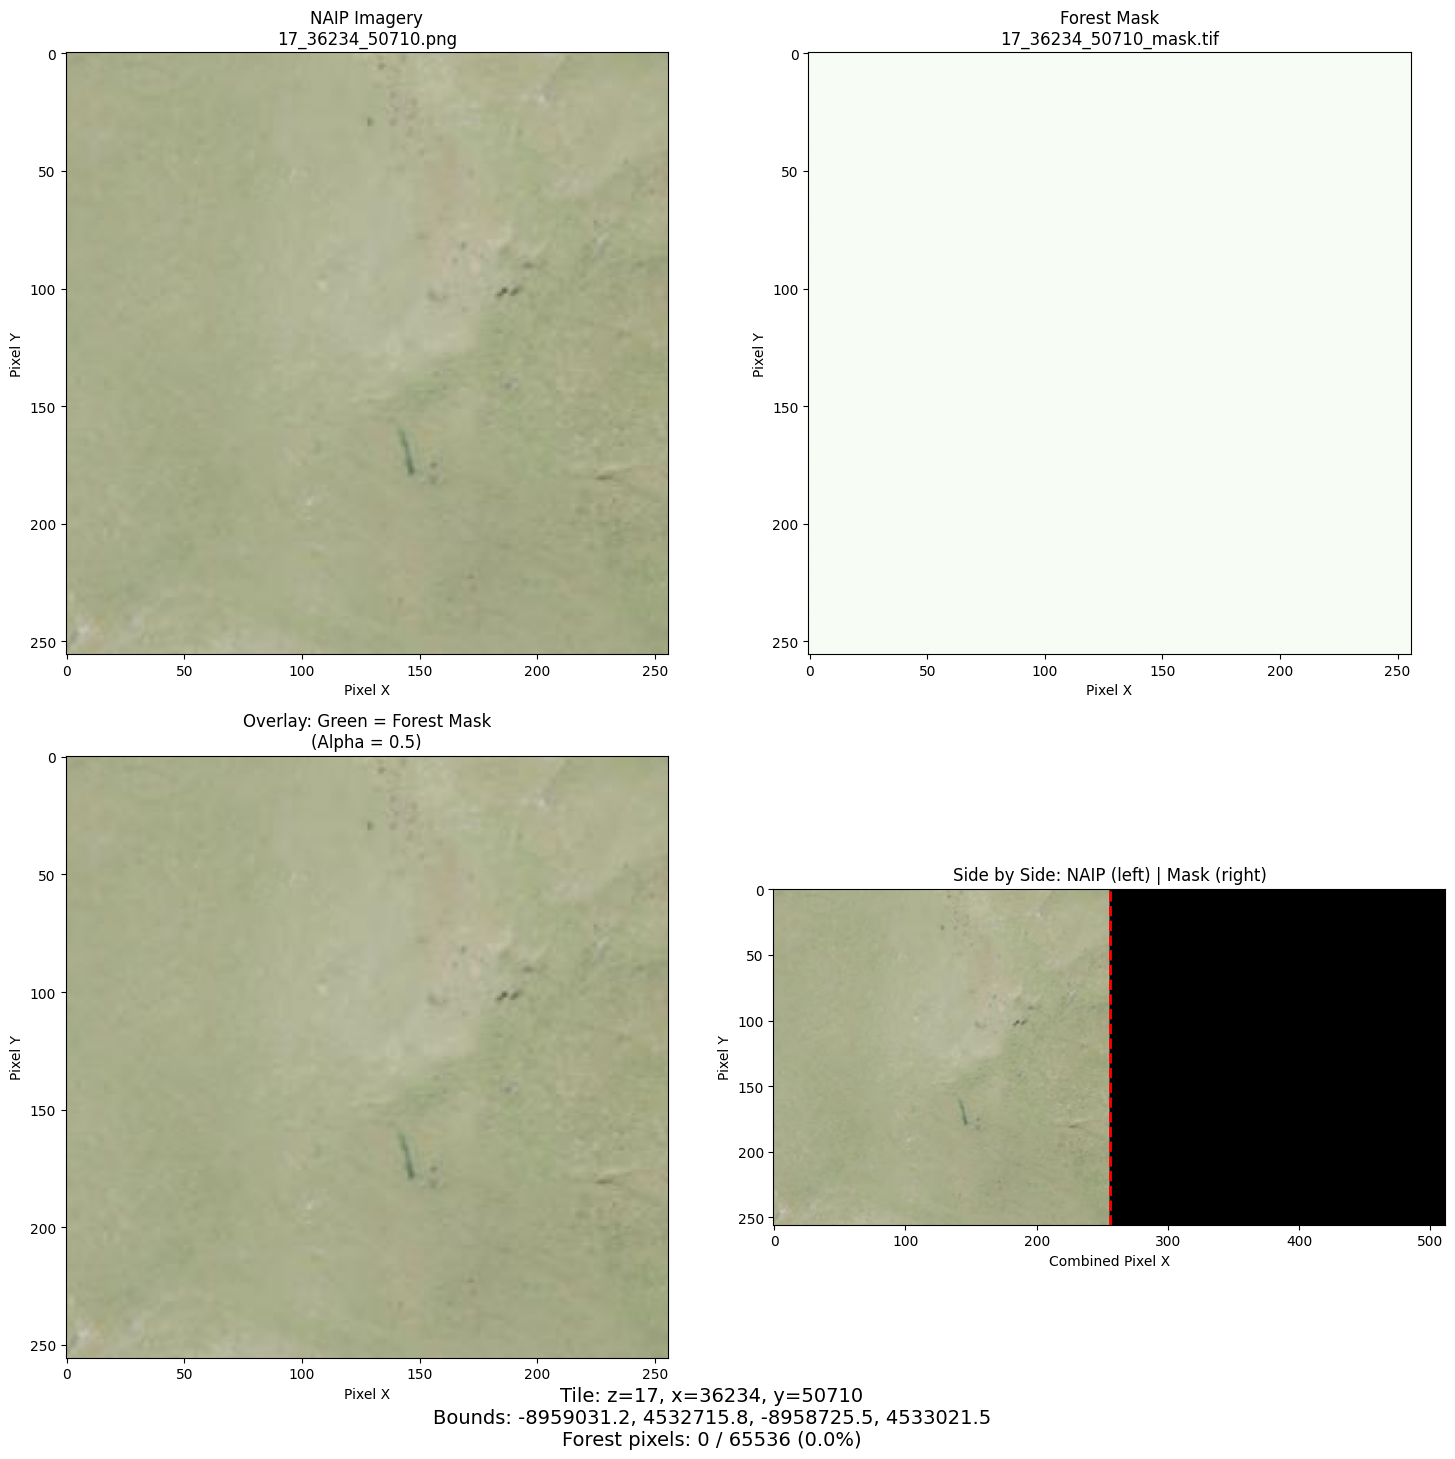


--- Sample 3 ---


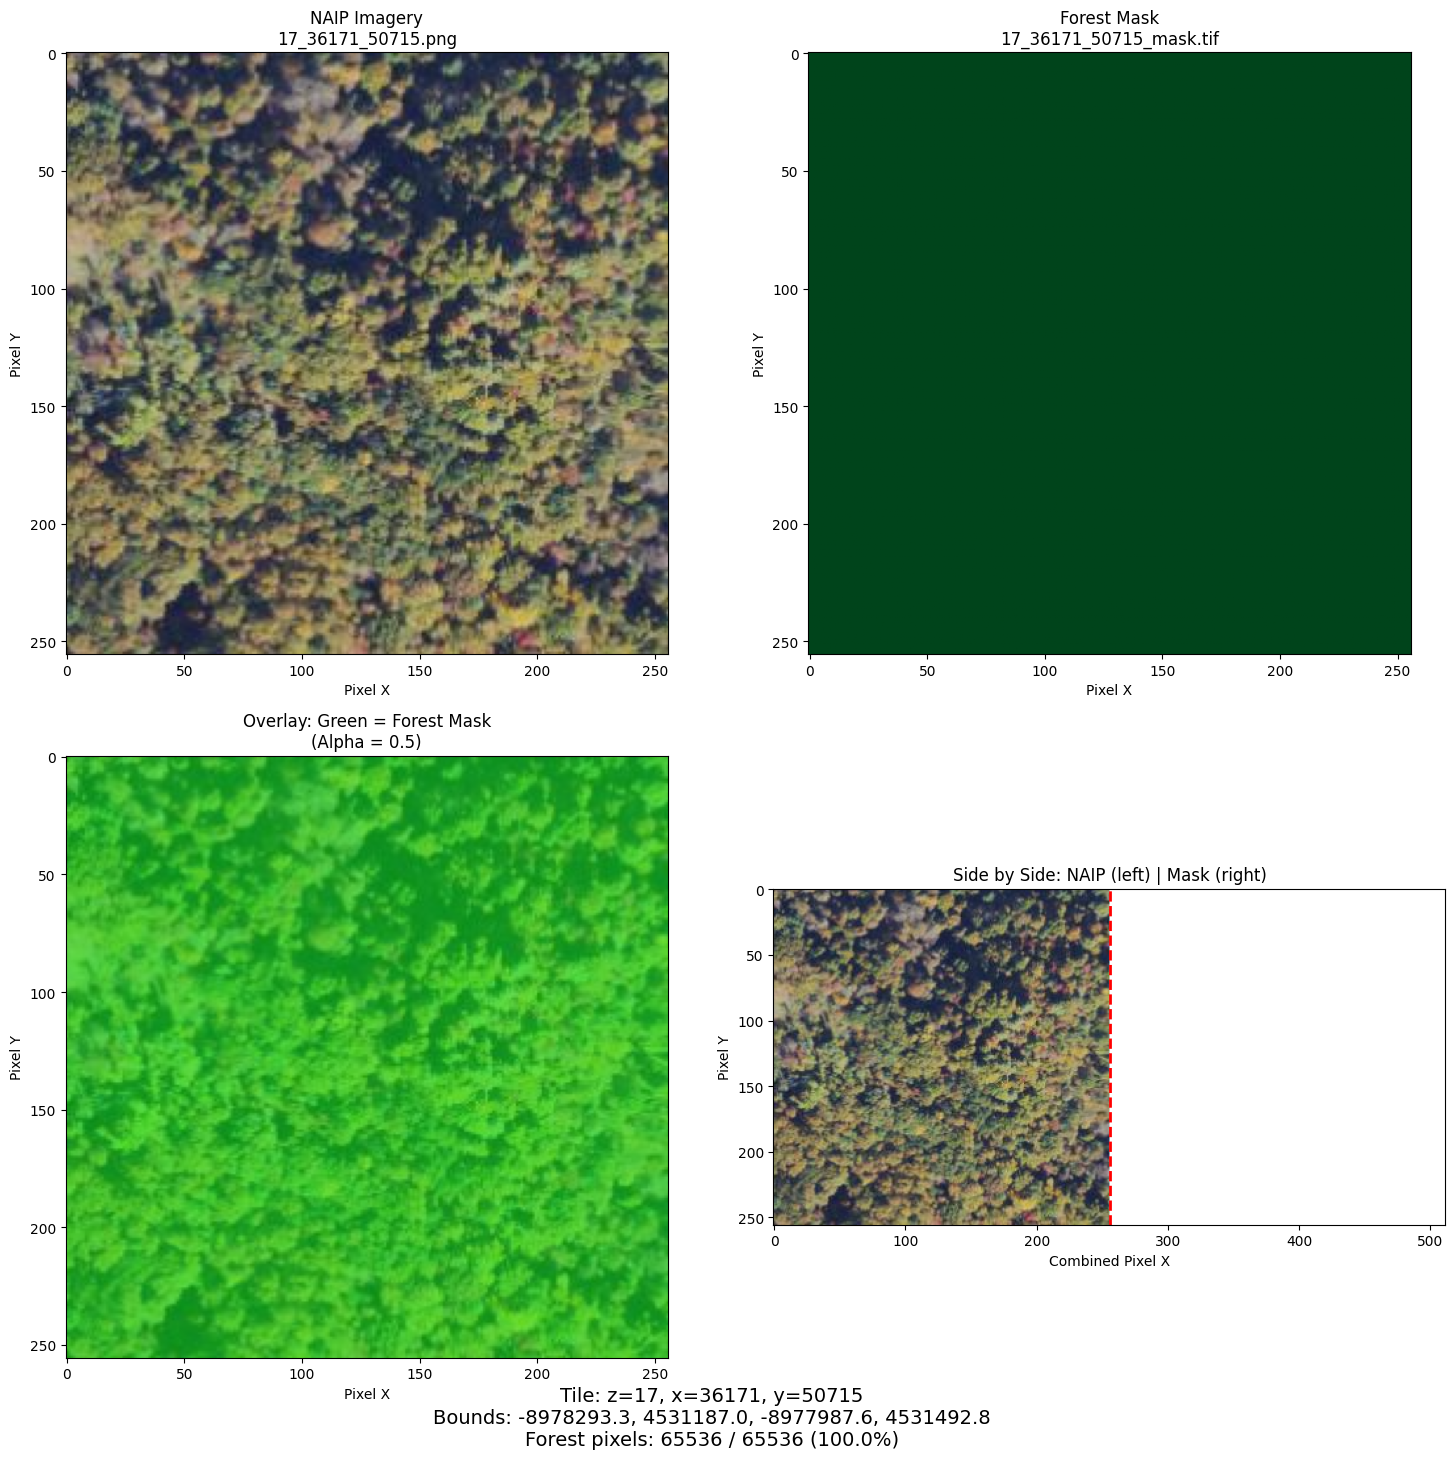


--- Sample 4 ---


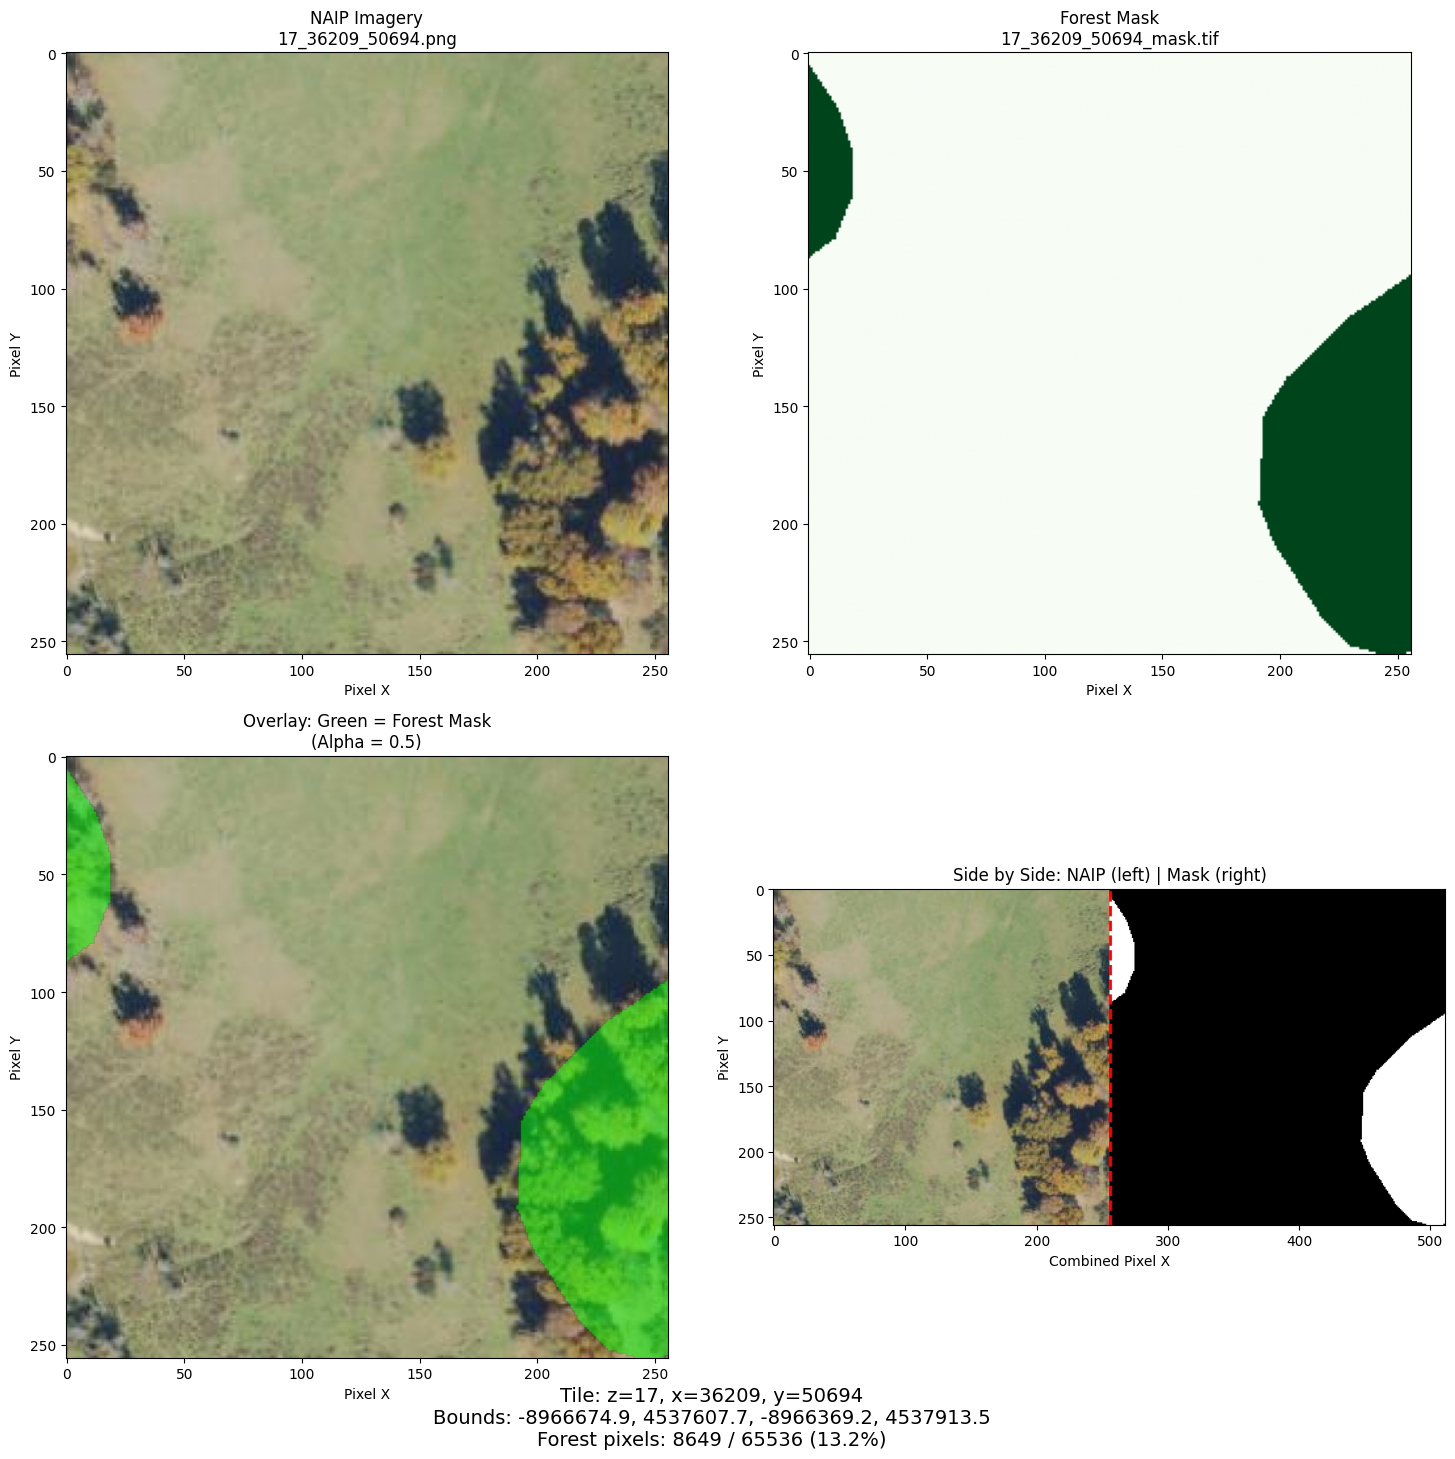


--- Sample 5 ---


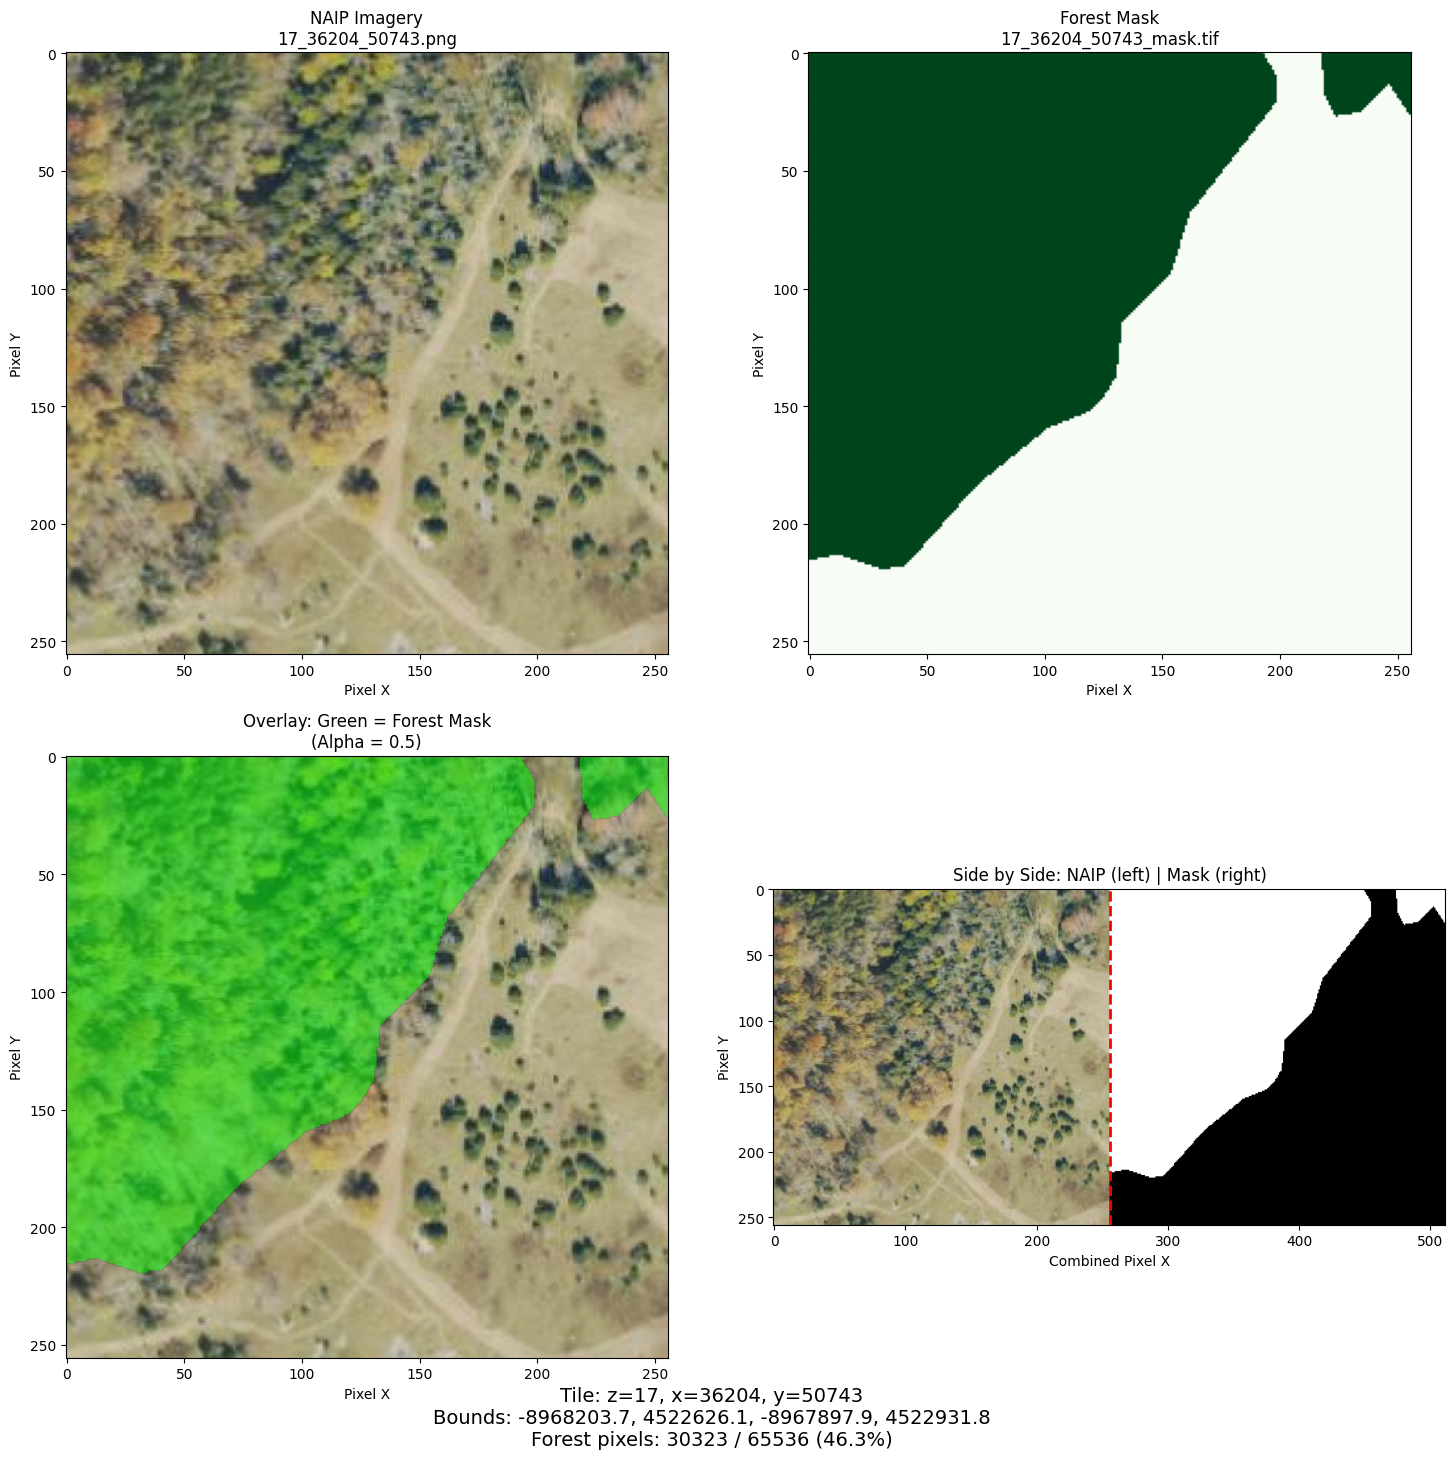

In [5]:
quick_random_comparison(5)

In [ ]:
interactive_tile_browser()